# Homework Assignment 5 - Chem 277B
## Flower Image Analysis

### 1) Objective

Before Convolutional Neural Networks (CNN) became available, K-means was an efficient method to segment images. Each pixel is represented by its RGB color vector. If we assume that pixel which belong to the same object should have the same color, then K-means should be able to cluster the pixel accordingly and therefore segment the image.<br> 
We want to analyze the Oxford 102 Flower Dataset using K-means clustering, hierarchical clustering, and decision tree classification and later in the course compare the results we obtain here to what we obtain using CNNs.<br>
<br>

### 2) Preparation

Before starting, we need to import the necessary libraries for data analysis and visualization.<br>
First, we import the standard libraries: 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from scipy.spatial.distance import pdist, squareform

Next, we need to load the dataset from `torchvision`

In [2]:
from torchvision.datasets import Flowers102 #pip install torchvision if necessary

Finally, we import our clustering methods:

In [3]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<br>

The dataset from `torchvision` contains various flower images and their corresponding labels.<br>
Run the following lines (it might take a few minutes!).

In [8]:
transforms = lambda x: np.array(x) / 255
dataset_train = Flowers102(root='Data', split='train', download=True, transform=transforms)
dataset_val = Flowers102(root='Data', split='val', download=True, transform=transforms)
dataset_test = Flowers102(root='Data', split='test', download=True, transform=transforms)
labels_train = np.array(dataset_train._labels)
labels_val = np.array(dataset_val._labels)
labels_test = np.array(dataset_test._labels)

In [5]:
classes = np.array(["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea","english marigold","tiger lily", "moon orchid",
    "bird of paradise", "monkshood","globe thistle", "snapdragon","colt's foot","king protea","spear thistle","yellow iris","globe-flower",
    "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily","fire lily","pincushion flower", "fritillary", "red ginger",
    "grape hyacinth","corn poppy", "prince of wales feathers","stemless gentian","artichoke","sweet william","carnation", "garden phlox",
    "love in the mist","mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",  "lenten rose",
    "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower","marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy","primula", "sunflower","pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?","cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily","rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia",
    "cyclamen",  "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea","camellia","mallow","mexican petunia",
    "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"])

<br>

2.1) We can display images in python using `plt.imshow(x)`, where *x* is the image. Show the first image from the dataset to understand what the data looks like.

In [108]:
# help(plt.imshow)

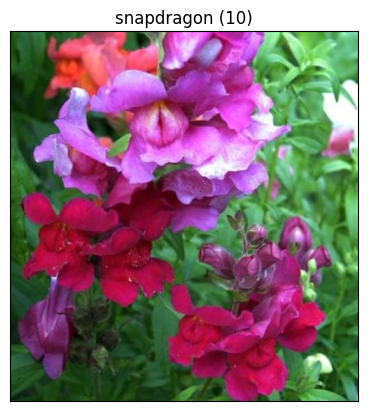

In [81]:
index = 100 #first image
x, y = dataset_train[index] #x: image, y: the label, classes[y]: the actual name of the flower (type str) 

def show(x,y):
    # show image
    plt.imshow(x)
    
    # add title/label and remove tick marks 
    ax = plt.gca()
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.title(f"{classes[y]} ({y})")

show(x,y)

2.2) Print the shape and type of the image. Generate three plots, each showing the image only in one color channel in gray scale (`cmap='gray'`)! 

datatype: <class 'numpy.ndarray'>
shape: (531, 500, 3)


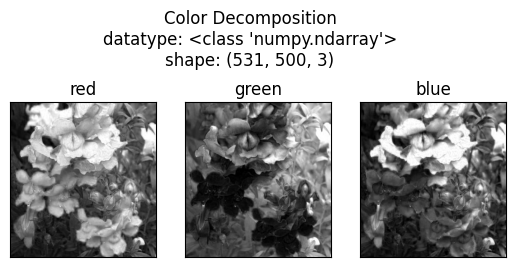

In [88]:
def show_decomposition(x):    
    str_datatype = f"datatype: {type(x)}"
    str_shape = f"shape: {x.shape}"
    print(str_datatype)
    print(str_shape)
    
    colors = ["red", "green", "blue",]
    fig, axs = plt.subplots(ncols=len(colors), squeeze=False)
    fig.suptitle("Color Decomposition\n"  + str_datatype + "\n" + str_shape, y=0.85)
    for i, color in enumerate(colors):
        axs[0,i].imshow(x[:,:,i], cmap='gray')
        axs[0,i].set_title(color)
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show_decomposition(x)

<br>

2.3) Show an image in the first 8 classes from the dataset to understand what the data looks like.

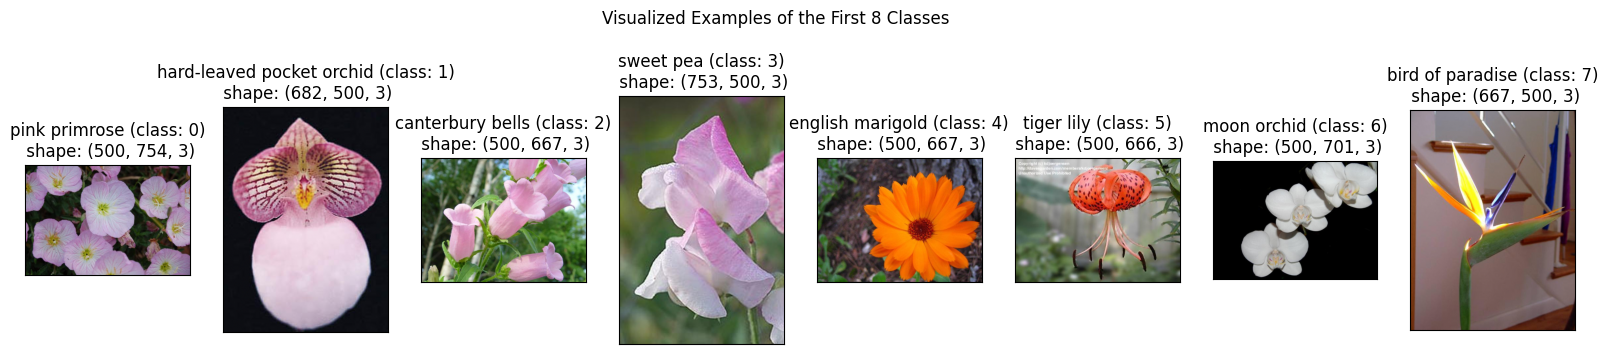

In [110]:
indices = [0, 10, 20, 30, 40, 50, 60, 70]

fig, axs = plt.subplots(ncols=len(indices), squeeze=False, figsize=(20,20))
fig.suptitle("Visualized Examples of the First 8 Classes", y=0.60)
for i, index in enumerate(indices):
        x, y = dataset_train[index]
        axs[0,i].imshow(x)
        axs[0,i].set_title(f"{classes[y]} (class: {y})\n shape: {x.shape}")
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### 3) Image Segmentation

3.1) Segment the first image in the training set using K-means clustering. Reshape the image into a 2D array where each row represents a pixel and each column represents a color channel (RGB), and then apply K-means clustering to cluster the pixels. Visualize the segmented image and discuss what you observe.

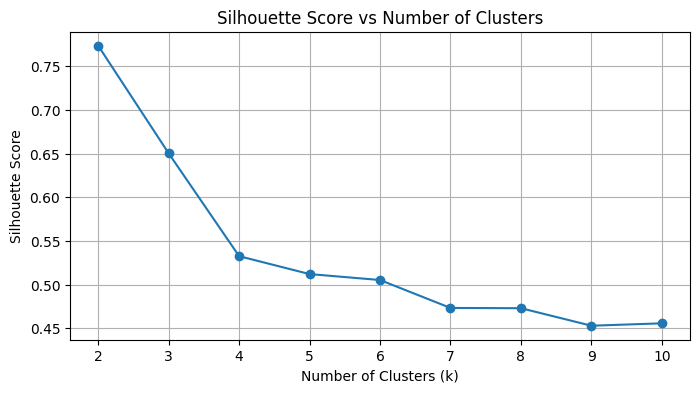

Optimal number of clusters: 2


In [143]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# reshape image
index = 0
x, y = dataset_train[index]
x_np = np.array(x)
x_reshaped = x_np.reshape(-1, 3)

# subsample pixels (otherwise this will take forever)
n_samples = 20000
indices = np.random.choice(x_reshaped.shape[0], n_samples, replace=False)
x_sampled = x_reshaped[indices]

# PCA
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x_sampled)

# Range of cluster counts to try
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_reduced)
    score = silhouette_score(x_reduced, labels)
    silhouette_scores.append(score)

# plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# best k
best_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {best_k}")

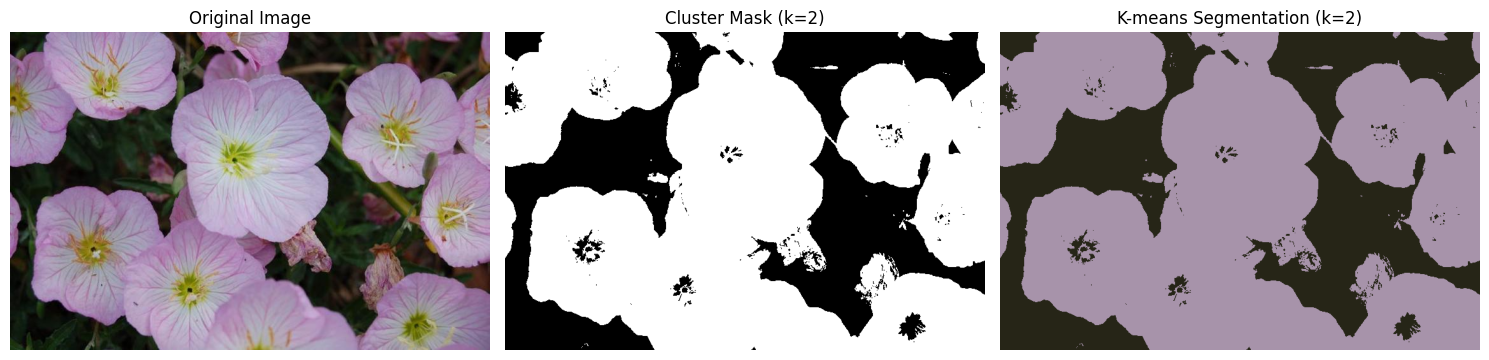

In [172]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load image and reshape
index = 0
x, y = dataset_train[index]  # x: image, y: label
x_np = np.array(x)
x_reshaped = x.reshape(-1, 3)  # (H*W, 3)

# number of clusters
k = best_k
kmeans = KMeans(n_clusters=k, random_state=42)
#kmeans.fit(x_reshaped)
labels = kmeans.fit_predict(x_reshaped)

# create cluster mask (label image)
# each pixel is assigned a cluster label
label_img = labels.reshape(x_np.shape[:2])  # (H, W)

# replace each pixel with its cluster center
# this will be the cluster's center color
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(x_np.shape)
#segmented_img = (segmented_img * 255).astype(np.uint8) # rescale colors... think about this

# plot original, segmented image and cluster mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(x_np)
ax[0].set_title("Original Image")
ax[0].axis("off")

# apply a colormap to cluster mask
ax[1].imshow(label_img, cmap="gray")  # or 'nipy_spectral', 'viridis'
ax[1].set_title(f"Cluster Mask (k={k})")
ax[1].axis("off")

# show cluster's center color
ax[2].imshow(segmented_img)
ax[2].set_title(f"K-means Segmentation (k={k})")
ax[2].axis("off")

plt.tight_layout()
plt.show()

*Visualize the segmented image and discuss what you observe.*

We began by estimating the optimal number of clusters for K-means image segmentation using silhouette scores across a range of candidate values.
To accelerate this process, we subsampled the pixel set and applied PCA to reduce the dimensionality from RGB to two principal components, allowing faster and more interpretable clustering.

The silhouette analysis revealed that the optimal number of clusters was two, which aligns with the visual structure of the image.
Each sample typically contains a flower and a background, thus forming two dominant regions.

Using K-means segmentation, we assigned each pixel a cluster label, producing a discrete segmentation map shown in the "Cluster Mask" subplot.
This mask highlights spatial regions grouped by color similarity, effectively separating foreground from background.

Finally, we replaced each pixel with its cluster’s centroid color, yielding a smoothed version of the image where each region is represented by its average color. This segmented image reveals the dominant color modes of the flower and background.

3.2) Visualize the center of each cluster as a color using `plt.imshow(colors.reshape(.., .., ..))`. What does this tell you about the image?

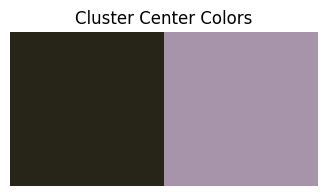

In [176]:
# visualize cluster centers as color swatches
colors = kmeans.cluster_centers_

#colors = (colors * 255).astype(np.uint8) # think about this

# reshape to a horizontal strip: (1, k, 3)
color_strip = colors.reshape(1, k, 3)

# show color strip
plt.figure(figsize=(8, 2))
plt.imshow(color_strip)
plt.title("Cluster Center Colors")
plt.axis("off")
plt.show()

*What does this tell you about the image?*

As we meantioned above we each pixel was replaced with its cluster’s centroid color.
This revealed the dominant color modes of the flower and background.

3.3) Reconstruct the image using the cluster centers and the labels assigned to each pixel. Does the reconstructed image capture the main features of the original image? Discuss your observations.

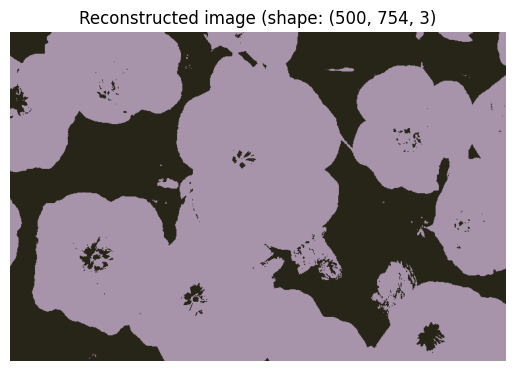

In [181]:
plt.imshow(colors[label_img].reshape(x_np.shape))
plt.axis('off')
plt.title(f'Reconstructed image (shape: {x_np.shape}')
plt.show()

*Discuss your observations.*

Again, we've already discussed this above.

We've replaced each pixel with its cluster’s centroid color, thus yielding an image where each region is represented by its cluster’s average color.
This segmented image reveals the dominant color modes of the flower and background.

### 4) Image Clustering

4.1) Use hierarchical clustering (`sns.clustermap`) to cluster the first 8 classes of images in the training set. Compute the mean color of the first image in the class and use the mean colors as features. Next, based on the mean colors, generate a distance square matrix (you can use `pdist(your_means, metric='euclidean')`) for clustering. Visualize the resulting dendrogram and discuss what you observe.

In [ ]:
indices = [0, 10, 20, 30, 40, 50, 60, 70]
ticks = classes[labels_train[indices]]

######## Fill in the code below ########

########################################

> your answer here!

<br>

### 5) Classification

5.1) Perform decision tree classification using `DecisionTreeClassifier` to predict the flower species based on the features from the K-means clustering. Train the decision tree classifier for class 0 (pink primrose) and class 4 (english marigold) on the training set and evaluate its performance on the validation set by creating a **confusion matrix plot** for both, training and evaluation set. Discuss why or why not the features from K-means clustering might be effective for this classification task.

In [ ]:
indices_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
indices_val = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

######## Fill in the code below ########
def extract_features(image, n_clusters=2):
....

tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)

....
########################################

> your answer here!

Visualize the decision tree and interpret the results. Discuss which features are most important for classification and how well the model performs. You can visualize the features as colors to help interpret the decision tree.

In [ ]:
plt.imshow(x_train.reshape(-1, n_clusters, 3))
plt.axis('off')
plt.title('Training features as colors')
plt.show()

plt.imshow(x_val.reshape(-1, n_clusters, 3))
plt.axis('off')
plt.title('Validation features as colors')
plt.show()

feature_names = [f'cluster{i}-{c}' for i in range(n_clusters) for c in ['red', 'green', 'blue']]
plot_tree(tree, filled=True, feature_names=feature_names, fontsize=10)
plt.show()

> your answer here!

5.2) Try a little more feature engineering by, for example, converting the RGB color space to HSV color space (`image = rgb_to_hsv(image)`) before applying K-means clustering, as well as sorting the cluster centers before flattening them into a feature vector. See if these changes improve the classification performance.

In [ ]:
indices_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
indices_val = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

######## Fill in the code below ########
def extract_features(image, n_clusters=2):

....
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)
....
########################################

> your answer here!

5.3) Try your final classification method on class 0 (pink primrose) and class 1 (hard-leaved pocket orchid). How well does it perform? Discuss what kind of features we have not considered that might help improve the classification.

In [ ]:
indices_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
indices_val = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

######## Fill in the code below ########

########################################

> your answer here!